# Classifier-free Guidance (CFG) の実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/3-4_classifier-free-guidance.ipynb)

## 準備

In [1]:
!pip install -qq py-img-gen

In [2]:
import warnings

import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
dtype = torch.float16
seed = 777

warnings.simplefilter("ignore", FutureWarning)

## CFG の実践

### Stable Diffusion パイプラインの読み込み

In [3]:
from diffusers import StableDiffusionPipeline

model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=dtype
)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### 勾配計算の無効化

In [4]:
torch.set_grad_enabled(False)

### ハイパーパラメータの定義

In [5]:
# 乱数生成器に指定されたシード値を設定
generator = torch.manual_seed(seed)
# 生成画像の解像度の指定
width = height = 512
# 画像生成する際の条件プロンプト
prompt = "A photo of an astronaut riding a horse"
# 逆拡散過程のステップ数
num_inference_steps = 50
# DDIM における eta (η) の値
eta = 0.0
# 今回は画像 1 枚を生成
batch_size = 1

### 入力値のバリデーション

In [6]:
pipe.check_inputs(
    prompt=prompt,
    width=width,
    height=height,
    callback_steps=1,
)

### 入力テキストの処理

#### 入力テキストのトークナイゼーション

In [7]:
cond_text_inputs = pipe.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
cond_text_input_ids = cond_text_inputs.input_ids
cond_text_input_ids

tensor([[49406,   320,  1125,   539,   550, 18376,  6765,   320,  4558, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

#### 入力テキストのエンコード

In [8]:
text_encoder_output = pipe.text_encoder(
    cond_text_input_ids.to(device),
)
cond_prompt_embeds = text_encoder_output.last_hidden_state
cond_prompt_embeds = cond_prompt_embeds.to(
    dtype=pipe.text_encoder.dtype, device=device
)

#### Nullテキストのトークナイゼーション

In [9]:
uncond_tokens = [""] * batch_size
uncond_text_inputs = pipe.tokenizer(
    uncond_tokens,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)
uncond_text_input_ids = uncond_text_inputs.input_ids
uncond_text_input_ids

tensor([[49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

#### Nullテキストのエンコード

In [10]:
text_encoder_output = pipe.text_encoder(
    uncond_text_input_ids.to(device)
)
uncond_prompt_embeds = text_encoder_output.last_hidden_state
uncond_prompt_embeds = uncond_prompt_embeds.to(
    dtype=pipe.text_encoder.dtype, device=device
)

### Noise Scheduler の設定

In [11]:
pipe.scheduler.set_timesteps(
    num_inference_steps, device=device
)
timesteps = pipe.scheduler.timesteps

### 潜在表現の準備

In [12]:
num_channels_latents = pipe.unet.config.in_channels
latents = pipe.prepare_latents(
    batch_size=batch_size,
    num_channels_latents=num_channels_latents,
    width=width,
    height=height,
    dtype=cond_prompt_embeds.dtype,
    device=device,
    generator=generator,
)

### 追加の引数の準備

In [13]:
kwargs = pipe.prepare_extra_step_kwargs(generator, eta)

### CFG のガイダンススケールの指定

In [14]:
guidance_scale = 7.5

### CFG の実行関数の定義

In [15]:
def classifier_free_guidance(
    cond_noise_pred: torch.Tensor,
    uncond_noise_pred: torch.Tensor,
    guidance_scale: float,
) -> torch.Tensor:
    return uncond_noise_pred + guidance_scale * (
        cond_noise_pred - uncond_noise_pred
    )

### CFG を適用した逆拡散過程の実行

In [16]:
progress_bar = pipe.progress_bar(total=num_inference_steps)

for i, t in enumerate(timesteps):
    latent_model_input = pipe.scheduler.scale_model_input(
        latents, t
    )
    # U-Net を使ってノイズを予測
    # 条件プロンプトを使ってノイズを予測
    cond_noise_pred = pipe.unet(
        latent_model_input,
        t,
        encoder_hidden_states=cond_prompt_embeds,
    ).sample
    # 無条件プロンプトを使ってノイズを予測
    uncond_noise_pred = pipe.unet(
        latent_model_input,
        t,
        encoder_hidden_states=uncond_prompt_embeds,
    ).sample
    # Classifier-free Guidance の適用
    noise_pred = classifier_free_guidance(
        cond_noise_pred=cond_noise_pred,
        uncond_noise_pred=uncond_noise_pred,
        guidance_scale=guidance_scale,
    )
    # 現在の状態 (x_t) から一つ前のステップの状態 (x_{t-1}) を予測
    latents = pipe.scheduler.step(
        noise_pred, t, latents, **kwargs
    ).prev_sample
    # プログレスバーの更新
    if (
        i == len(timesteps) - 1
        or (i + 1) % pipe.scheduler.order == 0
    ):
        progress_bar.update()

  0%|          | 0/50 [00:00<?, ?it/s]

### 潜在表現のデコード

In [17]:
scaling_factor = pipe.vae.scaling_factor
images = pipe.vae.decode(
    latents / scaling_factor, generator=generator
).sample

### NSFW の判定

In [18]:
images, has_nsfw_concept = pipe.run_safety_checker(
    image=images,
    device=device,
    dtype=cond_prompt_embeds.dtype,
)

### 潜在表現から画像への変換と表示

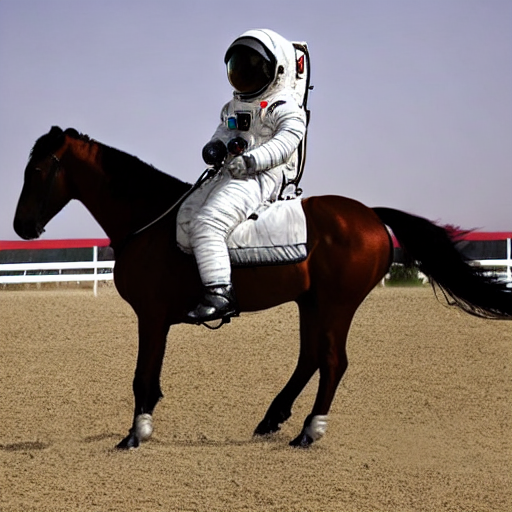

In [19]:
do_denormalize = [
    not has_nsfw for has_nsfw in has_nsfw_concept
]
images = pipe.image_processor.postprocess(
    images, do_denormalize=do_denormalize
)
images[0]

### ガイダンススケールと生成される画像の関係

#### ガイダンススケールを変えて画像を生成する関数の定義

In [20]:
from diffusers.utils import make_image_grid
from PIL import ImageOps
from PIL.Image import Image as PilImage


def exp_ablation(
    prompt: str,
    generator: torch.Generator,
    negative_prompt: str = "",
    guidance_scale: float = 7.5,
    n_images: int = 16,
) -> PilImage:
    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        guidance_scale=guidance_scale,
        num_images_per_prompt=n_images,
        generator=generator,
    )
    images = [
        ImageOps.expand(im, border=5, fill="white")
        for im in output.images
    ]
    return make_image_grid(
        images, rows=4, cols=n_images // 4
    )

#### ガイダンススケールを変えたときの生成結果の変化

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

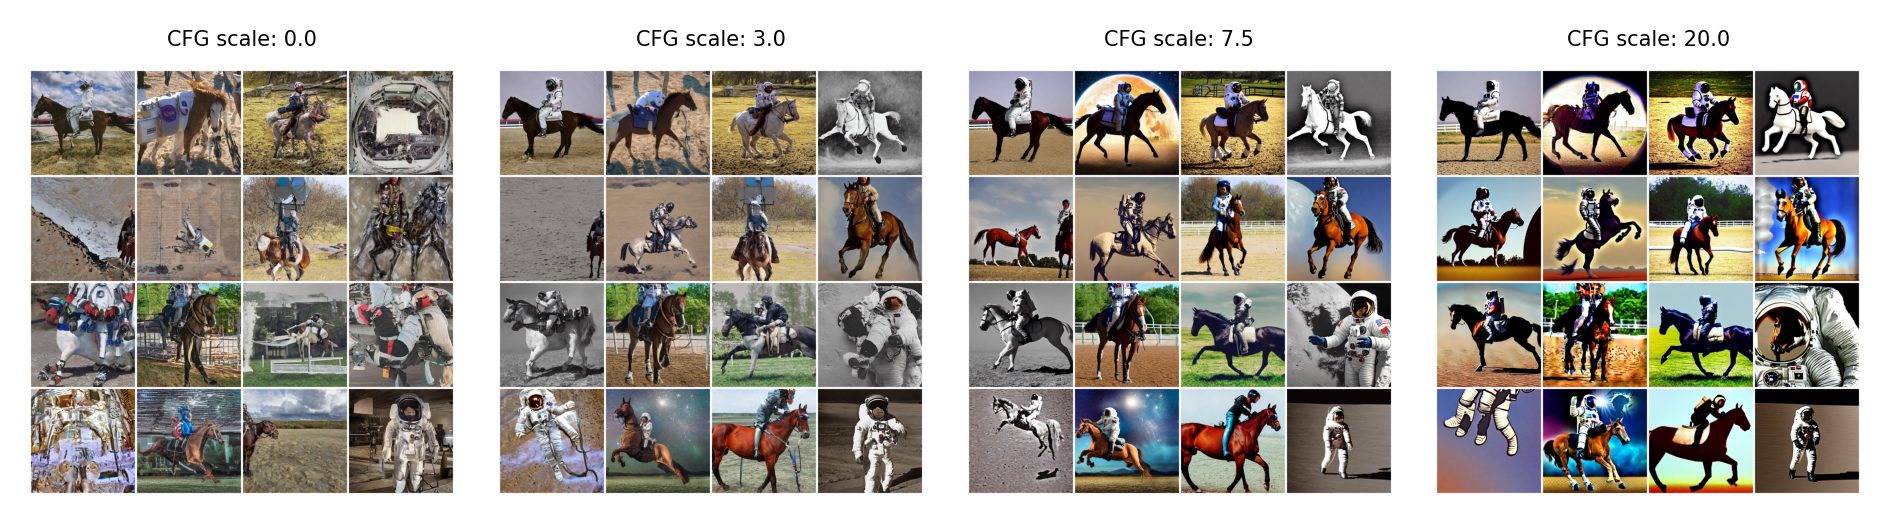

In [21]:
import matplotlib.pyplot as plt

guidance_scales = [0.0, 3.0, 7.5, 20.0]
fig, axes = plt.subplots(
    nrows=1, ncols=len(guidance_scales), dpi=300
)

for ax, guidance_scale in zip(axes, guidance_scales):
    image = exp_ablation(
        prompt=prompt,
        guidance_scale=guidance_scale,
        generator=torch.manual_seed(seed),
    )
    ax.set_title(f"CFG scale: {guidance_scale}", fontsize=5)

    ax.imshow(image)
    ax.axis("off")

fig.tight_layout()

## Negative Prompt の実践

### Negative Prompt の指定

In [22]:
negative_prompt = "Astronaut walking or floating"

### Negative Prompt による生成結果の変化

In [ ]:
fig, axes = plt.subplots(
    nrows=1, ncols=len(guidance_scales), dpi=300
)

for ax, guidance_scale in zip(axes, guidance_scales):
    image = exp_ablation(
        prompt=prompt,
        negative_prompt=negative_prompt,
        guidance_scale=guidance_scale,
        generator=torch.manual_seed(seed),
    )
    ax.set_title(f"CFG scale: {guidance_scale}", fontsize=5)

    ax.imshow(image)
    ax.axis("off")

fig.tight_layout()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]